In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
from TDECalculator import TDECalculator

plt.style.use("plot_style.mplstyle")
plt.rc('text', usetex=True)


## Call the TDE calculator class

In [ ]:
# MBH is the black hole masses, in units of solar masses
# Rp is the pericenter distance, in units of G MBH
# N is the number of steps in the time integration
calc = TDECalculator('MAMS1Msun', MBH=1e6, Rp=11.0, N=1000)

## Plot the deformed star's equator density

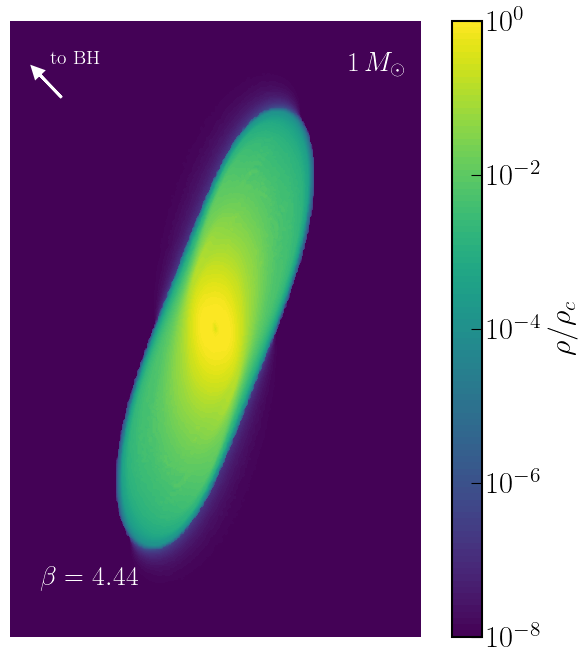

In [3]:
# Use the “equator_sample” method to get POS and dMass.
# Here we use equator_sample to get an equatorial slice:
equator_sample = calc.equator_sample(n_phi=3000)
POS    = equator_sample['POS']        # shape (n_r, 1, n_phi, 3)
dMass  = equator_sample['dMass']      # shape (n_r, n_phi)

# flatten x, y, and mass
x_pos   = POS[...,0].flatten()
y_pos   = POS[...,1].flatten()
mass_flat = dMass.flatten()

# define histogram bin edges
nbins   = 300
x_edges = np.linspace(-2, 2, nbins+1)
y_edges = np.linspace(-3, 3, nbins+1)

# build 2D mass histogram
mass_hist, x_edges, y_edges = np.histogram2d(
    x_pos, y_pos,
    bins=[x_edges, y_edges],
    weights=mass_flat
)

# convert to surface density
dx    = x_edges[1] - x_edges[0]
dy    = y_edges[1] - y_edges[0]
area  = dx*dy
density2D = mass_hist / area
# add tiny non‑constant offset for stable contours
Xc, Yc = np.meshgrid(
    0.5*(x_edges[:-1]+x_edges[1:]),
    0.5*(y_edges[:-1]+y_edges[1:])
)
density2D += 1e-12*(Xc + Yc)

# prepare interpolation onto a finer grid
points = np.column_stack((Xc.flatten(), Yc.flatten()))
values = density2D.T.flatten()
xi     = np.linspace(Xc.min(), Xc.max(), nbins-1)
yi     = np.linspace(Yc.min(), Yc.max(), nbins-1)
XI, YI = np.meshgrid(xi, yi)
dens_interp = griddata(points, values, (XI, YI), method='linear')
# normalize for plotting
dens_interp += dens_interp.max()*1e-8
dens_interp /= dens_interp.max()

# — plot! —
plt.figure(figsize=(8,8))
levels = np.logspace(
    np.log10(dens_interp[dens_interp>0].min()),
    np.log10(dens_interp.max()),
    100
)
cf = plt.contourf(
    XI, YI, dens_interp,
    levels=levels,
    cmap='viridis',
    norm=LogNorm()
)
cf.set_edgecolor('face')

# arrow pointing “to BH”
phi0 = calc.Phi_TDE
plt.arrow(-1.5, 2.25, -0.3*np.cos(phi0), -0.3*np.sin(phi0),
          linewidth=2, head_width=0.1, head_length=0.1, color='white')
plt.text(-1.5-0.3*np.cos(phi0)+0.1,
         2.25-0.3*np.sin(phi0)+0.1,
         'to BH', color='white', fontsize=14)

# annotate mass and β
beta = calc.Rtidal / calc.Rp
plt.text(1.3, 2.5,  fr'${calc.star_name[4:-4]}\,M_\odot$',
         color='white', fontsize=20)
plt.text(-1.7, -2.5, fr'$\beta={beta:.2f}$',
         color='white', fontsize=20)

plt.axis('scaled')
plt.axis('off')
plt.colorbar(cf, label='$\\rho/\\rho_c$', ticks=[1e-8, 1e-6, 1e-4, 1e-2, 1])
plt.show()


## Compute $dM/dE$ and $dM/dT$

In [ ]:
# N_Omega is the number of angular cells of the grid used to sample the star
whole_star_sample = calc.whole_star_sample(N_Omega=300**2)

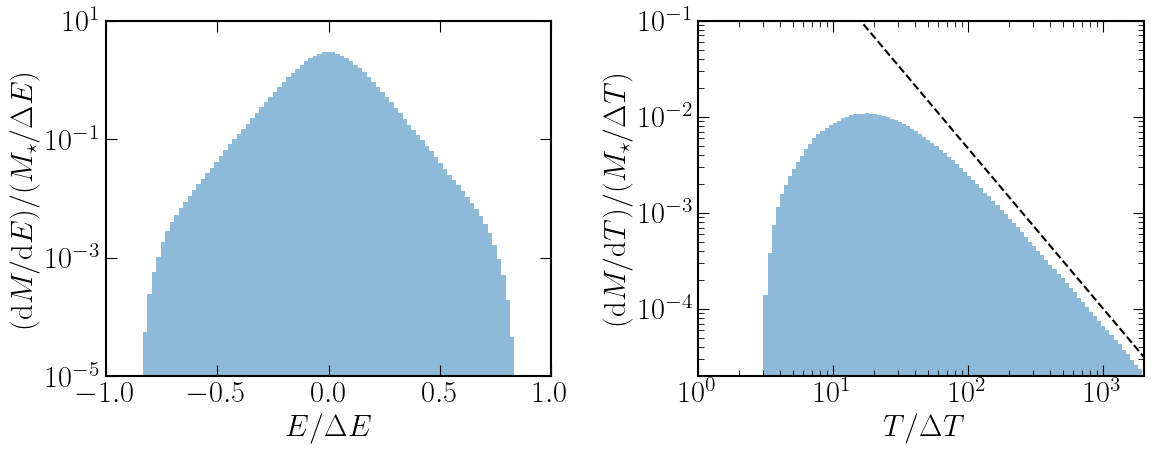

In [ ]:
# unpack
dE_rand   = whole_star_sample['dEnergy_random']      # shape (nr-1, N_Omega)
dE_unp    = whole_star_sample['dEnergy_unperturbed']
dT_rand   = whole_star_sample['dT_random']
dT_unp    = whole_star_sample['dT_unperturbed']
dMass     = whole_star_sample['dMass']               # same shape

# set up figure
fig, (axE, axT) = plt.subplots(1, 2, figsize=(12,5))

# histograms in E
bins_E = np.linspace(-2, 2, 200)
axE.hist(dE_rand.flatten(),
         weights=dMass.flatten(),
         bins=bins_E,
         density=True,
         alpha=0.5)
axE.set_yscale('log')
axE.set_xlim(-1,1)
axE.set_ylim(1e-5,10)
axE.set_xlabel(r'$ E / \Delta E$')
axE.set_ylabel(r'$(\mathrm{d}M/\mathrm{d}E) / (M_\star / \Delta E)$')

# histograms in T
bins_T = np.logspace(0, 6, 200)
axT.hist(dT_rand.flatten(),
         weights=dMass.flatten(),
         bins=bins_T,
         density=True,
         alpha=0.5)
# overplot T^{-5/3} reference
axT.plot(bins_T, 10*bins_T**(-5/3), 'k--', label=r'$T^{-5/3}$')
axT.set_xscale('log')
axT.set_yscale('log')
axT.set_xlim(1,2000)
axT.set_ylim(2e-5,0.1)
axT.set_xlabel(r'$T / \Delta T$')
axT.set_ylabel(r'$(\mathrm{d}M/\mathrm{d}T) / (M_\star / \Delta T)$')

plt.tight_layout()
plt.show()
